## Data Mining, Text Mining and Big Data Analytics
### BDA Project
### Junjie Zhu_1030002
### junjie.zhu3@studio.unibo.it

Dataset: Beijing Multi-Site Air-Quality Data.
    https://archive.ics.uci.edu/dataset/501/beijing+multi+site+air+quality+data

W

In [1]:
# Initialize Spark in Python environment
import findspark
findspark.init()

In [2]:
#Import reference library
import os
from functools import reduce
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql import DataFrame
from pyspark.sql.window import Window
from pyspark.sql.types import StructType, StructField, IntegerType, StringType, DoubleType
from pyspark.sql.functions import concat_ws,to_timestamp,col,count,when,udf,greatest,expr,array,lit,month,quarter,avg
from pyspark.ml.feature import VectorAssembler,StandardScaler,StringIndexer
from pyspark.ml.clustering import KMeans, BisectingKMeans
from pyspark.ml.regression import DecisionTreeRegressor, RandomForestRegressor, LinearRegression
from pyspark.ml.classification import NaiveBayes, DecisionTreeClassifier,RandomForestClassifier,LogisticRegression,MultilayerPerceptronClassifier
from pyspark.ml.evaluation import RegressionEvaluator, MulticlassClassificationEvaluator,ClusteringEvaluator

import matplotlib.pyplot as plt

SparkSession is the entry point to any Spark functionality in a Spark application. It provides a way to interact with Spark and allows to create DataFrame, Dataset, and RDD (Resilient Distributed Dataset) objects, which are the core data structures used in Spark.

In [3]:
# Initialize a SparkSession with specific configurations for memory allocation and other settings.
spark = SparkSession.builder.appName("AirQualityAnalysis").config("spark.sql.legacy.timeParserPolicy", "LEGACY")\
                                            .config("spark.executor.memory", "4g")\
                                            .config("spark.driver.memory", "2g")\
                                            .config("spark.executor.cores", "2")\
                                            .getOrCreate()

In [4]:
# Read csv data files as dataframe in a fixed type
path = "D:\\UNIBO\\BigData\\data set\\beijing+multi+site+air+quality+data\\PRSA_Data_20130301-20170228"

df = {}
station_name = ['Aotizhongxin','Changping','Dingling','Dongsi','Guanyuan','Gucheng','Huairou','Nongzhanguan','Shunyi','Tiantan','Wanliu','Wanshouxigong']

schema = StructType([
    StructField("No", IntegerType(), True),
    StructField("year", IntegerType(), True),
    StructField("month", IntegerType(), True),
    StructField("day", IntegerType(), True),
    StructField("hour", IntegerType(), True),
    StructField("PM2.5", IntegerType(), True),
    StructField("PM10", IntegerType(), True),
    StructField("SO2", IntegerType(), True),
    StructField("NO2", IntegerType(), True),
    StructField("CO", IntegerType(), True),
    StructField("O3", IntegerType(), True),
    StructField("TEMP", DoubleType(), True),
    StructField("PRES", DoubleType(), True),
    StructField("DEWP", DoubleType(), True),
    StructField("RAIN", DoubleType(), True),
    StructField("wd", StringType(), True),
    StructField("WSPM", DoubleType(), True),
    StructField("station", StringType(), True),
])

for i,filename in enumerate(os.listdir(path)):
    if filename.endswith(".csv"):
        filepath = os.path.join(path, filename)
        df[station_name[i]] = spark.read.csv(filepath, header=True, schema=schema)

The original data is stored in files of different observation base stations, thus use "unionByName" function to merge them into one dataframe. Then rename the PM2.5 column to PM25 to avoid subsequent error.

In [5]:
#Merge dataframe
def unionByName(*dfs):
    return reduce(DataFrame.unionByName, dfs)

df_list= list(map(lambda x: x[1], df.items()))
dfAll = unionByName(*df_list)
dfAll = dfAll.withColumnRenamed( "PM2.5" , "PM25" )
print("Total rows of data: ",dfAll.count())

Total rows of data:  420768


The data contains time characteristics, so change the time data into the timestamp format.

In [6]:
# Use the concat_ws() function to combine year, month, day, hour into a datetime string column
dfAll = dfAll.withColumn("datetime_str", concat_ws("-", "year", "month", "day", "hour"))
dfAll = dfAll.withColumn("timestamp", to_timestamp("datetime_str", "yyyy-MM-dd-HH"))
dfAll = dfAll.drop("datetime_str")

The data contains null values, which may mean that the sensor fails to collect data or other reasons. In order to avoid the impact of null values on the analysis, the entire row of data corresponding to null values will be cleared.

In [7]:
# Clear rows which has null values
df = dfAll.na.drop()
print("Data without null values has row:",df.count())
df.show()

Data without null values has row: 373579
+---+----+-----+---+----+----+----+---+---+---+---+----+------+-----+----+---+----+------------+-------------------+
| No|year|month|day|hour|PM25|PM10|SO2|NO2| CO| O3|TEMP|  PRES| DEWP|RAIN| wd|WSPM|     station|          timestamp|
+---+----+-----+---+----+----+----+---+---+---+---+----+------+-----+----+---+----+------------+-------------------+
|  1|2013|    3|  1|   0|   4|   4|  4|  7|300| 77|-0.7|1023.0|-18.8| 0.0|NNW| 4.4|Aotizhongxin|2013-03-01 00:00:00|
|  2|2013|    3|  1|   1|   8|   8|  4|  7|300| 77|-1.1|1023.2|-18.2| 0.0|  N| 4.7|Aotizhongxin|2013-03-01 01:00:00|
|  3|2013|    3|  1|   2|   7|   7|  5| 10|300| 73|-1.1|1023.5|-18.2| 0.0|NNW| 5.6|Aotizhongxin|2013-03-01 02:00:00|
|  4|2013|    3|  1|   3|   6|   6| 11| 11|300| 72|-1.4|1024.5|-19.4| 0.0| NW| 3.1|Aotizhongxin|2013-03-01 03:00:00|
|  5|2013|    3|  1|   4|   3|   3| 12| 12|300| 72|-2.0|1025.2|-19.5| 0.0|  N| 2.0|Aotizhongxin|2013-03-01 04:00:00|
|  6|2013|    3|  1|   

Null values can also be understood as outliers. The following statistics are based on time and location for the empty data.

In [8]:
# Outlier Analysis
time_column = "timestamp"
min_time = dfAll.selectExpr(f"min(`{time_column}`)").collect()[0][0]
max_time = dfAll.selectExpr(f"max(`{time_column}`)").collect()[0][0]
print("The statistical time of the data starts from {} to {}.".format(min_time, max_time))

# Find the rows that has null value
df_outlier = dfAll.exceptAll(df)
print("Number of outlier data:",df_outlier.count())

df_outlier_group = df_outlier.groupBy("year", "month","day","station").count()
df_outlier_group.show()

The statistical time of the data starts from 2013-03-01 00:00:00 to 2017-02-28 23:00:00.
Number of outlier data: 47189
+----+-----+---+------------+-----+
|year|month|day|     station|count|
+----+-----+---+------------+-----+
|2015|    4| 13|Aotizhongxin|    2|
|2013|    7| 31|Aotizhongxin|    3|
|2016|    9|  7|   Changping|   11|
|2016|    8|  1|    Dingling|   12|
|2013|   11|  1|    Dingling|   24|
|2016|    7| 28|    Dingling|   13|
|2013|    7|  3|      Dongsi|   24|
|2013|    3|  8|      Dongsi|    1|
|2013|   11| 13|      Dongsi|   24|
|2015|   11| 21|     Gucheng|    1|
|2016|    5| 27|     Gucheng|    2|
|2014|   10|  4|     Gucheng|    1|
|2013|    7| 21|     Huairou|    1|
|2014|    3| 30|Nongzhanguan|    1|
|2016|    9| 11|      Shunyi|   24|
|2016|    9| 22|      Shunyi|   24|
|2015|    9| 11|      Shunyi|    2|
|2014|    5| 13|     Tiantan|   16|
|2013|   11| 29|      Wanliu|   24|
|2014|    1|  2|      Wanliu|   24|
+----+-----+---+------------+-----+
only showing top 

Perform specific analysis on temperature data, such as the average temperature of each season, the average temperature of each month, and the trend of average temperature changes.

+------+----------------------------+
|season|average_seasonal_temperature|
+------+----------------------------+
|     1|          2.6420255396806676|
|     2|          20.460400593356873|
|     3|          24.901560071199754|
|     4|          5.9649532572357415|
+------+----------------------------+



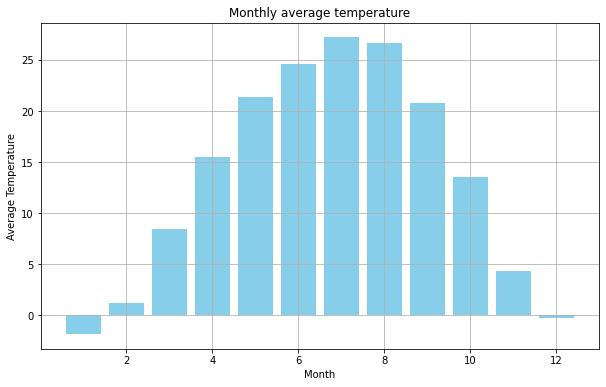

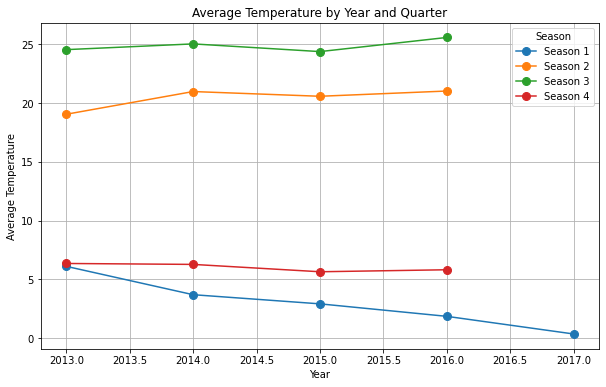

In [9]:
# Analyze average temperatures
df = df.withColumn("season", quarter("timestamp"))

avg_temp = df.groupBy("year","season").agg(avg("TEMP").alias("average_temperature"))
seasonal_avg_temp = df.groupBy("season").agg(avg("TEMP").alias("average_seasonal_temperature"))
monthly_avg_temp = df.groupBy("month").agg(avg("TEMP").alias("average_mounthly_temperature"))

seasonal_avg_temp = seasonal_avg_temp.orderBy("season")
seasonal_avg_temp.show()
avg_temp = avg_temp.orderBy("year")

# Monthly average temperature
months = monthly_avg_temp.select("month").rdd.flatMap(lambda x: x).collect()
temperatures = monthly_avg_temp.select("average_mounthly_temperature").rdd.flatMap(lambda x: x).collect()

plt.figure(figsize=(10, 6))
plt.bar(months, temperatures, color='skyblue')
plt.xlabel("Month")
plt.ylabel("Average Temperature")
plt.title("Monthly average temperature")
plt.grid(True)
plt.show()


# Average Temperature by Year and Quarter
pandas_df = avg_temp.toPandas()
grouped_data = pandas_df.groupby(['year', 'season'])['average_temperature'].mean().unstack()
grouped_data.plot(kind='line', figsize=(10, 6), style='o-', markersize=8)

plt.xlabel("Year")
plt.ylabel("Average Temperature")
plt.title("Average Temperature by Year and Quarter")
plt.legend(title='Season', labels=['Season 1', 'Season 2', 'Season 3', 'Season 4'])
plt.grid(True)
plt.show()

From the above results, it can be seen that there are obvious seasonal changes and annual temperature changes. The most obvious is that the temperature in the first quarter is getting lower and lower.

## PM2.5 Cluster
PM2.5 refers to particles with a diameter less than or equal to 2.5 microns. They are so small that they can be suspended in the air and can be inhaled into the lungs by the human body. Due to its special nature, PM2.5 is affected by many factors, including meteorological conditions, human activities and natural factors.
Therefore, clustering algorithms are used to analyze its relationship with seasonal changes.

In [10]:
# Seasonal averages of PM2.5.
avg_pm25 = df.groupBy("season").agg(avg("PM25").alias("average_pm25"))
avg_pm25 = avg_pm25.orderBy("season")
avg_pm25.show()

+------+-----------------+
|season|     average_pm25|
+------+-----------------+
|     1|91.20726815233421|
|     2|68.12609705180641|
|     3|61.43240575649516|
|     4|98.32022916290002|
+------+-----------------+



In [11]:
# Cluster analysis of PM2.5 values using kmeans algorithm
assembler = VectorAssembler(inputCols=["PM25"], outputCol="features")
PM25_features = assembler.transform(df)

k = 4
kmeans = KMeans().setK(k).setSeed(42)
modelkm = kmeans.fit(PM25_features)

cluster_centers = modelkm.clusterCenters()
print("The 4 characteristic values of PM2.5 are:",cluster_centers)

evaluator = ClusteringEvaluator()
silhouette_scorekm = evaluator.evaluate(modelkm.transform(PM25_features))
print(f"Silhouette Score of KMeans: {silhouette_scorekm}")

The 4 characteristic values of PM2.5 are: [array([97.69230701]), array([26.43808674]), array([196.60968143]), array([355.08300528])]
Silhouette Score of KMeans: 0.7617583141535191


In [12]:
# BisectingKMeans clustering algorithm
bkm = BisectingKMeans(k=2, minDivisibleClusterSize=1.0, seed=11)
bkm.setMaxIter(20)

modelbkm = bkm.fit(PM25_features)
evaluatorbkm = ClusteringEvaluator()
silhouette_scorebkm = evaluatorbkm.evaluate(modelbkm.transform(PM25_features))
print(f"Silhouette Score: {silhouette_scorebkm}")
cluster_centersbkm = modelbkm.clusterCenters()
print("The 2 characteristic values of PM2.5 are:",cluster_centersbkm)

Silhouette Score: 0.8138285072856454
The 2 characteristic values of PM2.5 are: [array([47.02957721]), array([208.58088343])]


The Silhouette Score is a measure of how well-defined the clusters are in a clustering algorithm like KMeans. It ranges from -1 to 1, where a higher value indicates that the clusters are well-separated and distinct.

The above results with Silhouette Score as 0.7617583141535191 for the KMeans clustering and 0.7456583043645952 for the BisectingKMeans clustering suggests that the clusters are relatively well-separated and distinct. This value indicates that the KMeans algorithm has done a good job in finding meaningful and compact clusters for the given data.

## Station Classification

In [13]:
indexerwd = StringIndexer(inputCol="wd", outputCol="encoded_wd")
indexed_wd = indexerwd.fit(df)
df_encoded = indexed_wd.transform(df)
indexerst = StringIndexer(inputCol="station", outputCol="encoded_station")
indexed_st = indexerst.fit(df_encoded)
df_encoded = indexed_st.transform(df_encoded)
df_encoded.select(["wd", "encoded_wd","station","encoded_station"]).show()

+---+----------+------------+---------------+
| wd|encoded_wd|     station|encoded_station|
+---+----------+------------+---------------+
|NNW|       7.0|Aotizhongxin|            6.0|
|  N|       3.0|Aotizhongxin|            6.0|
|NNW|       7.0|Aotizhongxin|            6.0|
| NW|       2.0|Aotizhongxin|            6.0|
|  N|       3.0|Aotizhongxin|            6.0|
|  N|       3.0|Aotizhongxin|            6.0|
|NNE|       6.0|Aotizhongxin|            6.0|
|NNW|       7.0|Aotizhongxin|            6.0|
|NNW|       7.0|Aotizhongxin|            6.0|
|  N|       3.0|Aotizhongxin|            6.0|
|NNW|       7.0|Aotizhongxin|            6.0|
|  N|       3.0|Aotizhongxin|            6.0|
|NNW|       7.0|Aotizhongxin|            6.0|
| NW|       2.0|Aotizhongxin|            6.0|
| NW|       2.0|Aotizhongxin|            6.0|
|NNE|       6.0|Aotizhongxin|            6.0|
|NNW|       7.0|Aotizhongxin|            6.0|
|NNE|       6.0|Aotizhongxin|            6.0|
|NNE|       6.0|Aotizhongxin|     

In [15]:
assembler_station = VectorAssembler(inputCols=["PM25", "PM10","SO2","NO2","CO","O3","TEMP","PRES","DEWP","RAIN","encoded_wd","WSPM"], outputCol="features")
df_encoded_feature = assembler_station.transform(df_encoded)

station_col = ["features","encoded_station"]
station_features = df_encoded_feature.select(*station_col)
station_features = station_features.withColumnRenamed('encoded_station', 'label')
station_features.show()

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[4.0,4.0,4.0,7.0,...|  6.0|
|[8.0,8.0,4.0,7.0,...|  6.0|
|[7.0,7.0,5.0,10.0...|  6.0|
|[6.0,6.0,11.0,11....|  6.0|
|[3.0,3.0,12.0,12....|  6.0|
|[5.0,5.0,18.0,18....|  6.0|
|[3.0,3.0,18.0,32....|  6.0|
|[3.0,6.0,19.0,41....|  6.0|
|[3.0,6.0,16.0,43....|  6.0|
|[3.0,8.0,12.0,28....|  6.0|
|[3.0,6.0,9.0,12.0...|  6.0|
|[3.0,6.0,9.0,14.0...|  6.0|
|[3.0,6.0,7.0,13.0...|  6.0|
|[3.0,6.0,7.0,12.0...|  6.0|
|[6.0,9.0,7.0,11.0...|  6.0|
|[8.0,15.0,7.0,14....|  6.0|
|[9.0,19.0,9.0,13....|  6.0|
|[10.0,23.0,11.0,1...|  6.0|
|[11.0,20.0,8.0,20...|  6.0|
|[8.0,14.0,12.0,30...|  6.0|
+--------------------+-----+
only showing top 20 rows



In [16]:
normaliser = StandardScaler(inputCol="features", outputCol="normFeatures")
normModel = normaliser.fit(station_features)
station_norm = normModel.transform(station_features)
station_features_norm = station_norm.select(["normFeatures", "label"])
station_features_norm.show(3)

+--------------------+-----+
|        normFeatures|label|
+--------------------+-----+
|[0.04980570681925...|  6.0|
|[0.09961141363851...|  6.0|
|[0.08715998693369...|  6.0|
+--------------------+-----+
only showing top 3 rows



In [17]:
train, test = station_features_norm.randomSplit([0.67, 0.33],seed=15)

In [18]:
dt = DecisionTreeClassifier(maxDepth=12, featuresCol="normFeatures",labelCol="label", leafCol="leafId")
modeldt = dt.fit(train)
dt_test = modeldt.transform(test)
dt_test.select('prediction', 'label').show(3)

evaluator_dt = MulticlassClassificationEvaluator()
accuracy_dt = evaluator_dt.evaluate(dt_test, {evaluator_dt.metricName: "accuracy"})
print("The accuracy of DecisionTreeClassifier is:",accuracy_dt)

+----------+-----+
|prediction|label|
+----------+-----+
|       3.0|  6.0|
|       3.0|  6.0|
|       4.0|  6.0|
+----------+-----+
only showing top 3 rows

The accuracy of DecisionTreeClassifier is: 0.23473401623721582


In [19]:
rf = RandomForestClassifier(numTrees=6, maxDepth=12, featuresCol="normFeatures",labelCol="label", seed=42,leafCol="leafId")
modelrf = rf.fit(train)
rf_test = modelrf.transform(test)

evaluator_rf = MulticlassClassificationEvaluator()
accuracy_rf = evaluator_rf.evaluate(rf_test, {evaluator_rf.metricName: "accuracy"})
print("The accuracy of RandomForestClassifier is:",accuracy_rf)

The accuracy of RandomForestClassifier is: 0.26264223784844726


Because the data were collected from 12 different base stations, it was planned to predict the collection points through multi-classifiers, but the accuracy results of the above two classifiers showed that this scheme was not applicable.

The reason may be that the air data differences are not obvious because the collection points are all located in one city and the geographical location is relatively close.

## AQI

In [20]:
df_AQI = df.select("timestamp", "PM25","PM10","SO2","NO2","CO","O3","station")
df_AQI.show()

+-------------------+----+----+---+---+---+---+------------+
|          timestamp|PM25|PM10|SO2|NO2| CO| O3|     station|
+-------------------+----+----+---+---+---+---+------------+
|2013-03-01 00:00:00|   4|   4|  4|  7|300| 77|Aotizhongxin|
|2013-03-01 01:00:00|   8|   8|  4|  7|300| 77|Aotizhongxin|
|2013-03-01 02:00:00|   7|   7|  5| 10|300| 73|Aotizhongxin|
|2013-03-01 03:00:00|   6|   6| 11| 11|300| 72|Aotizhongxin|
|2013-03-01 04:00:00|   3|   3| 12| 12|300| 72|Aotizhongxin|
|2013-03-01 05:00:00|   5|   5| 18| 18|400| 66|Aotizhongxin|
|2013-03-01 06:00:00|   3|   3| 18| 32|500| 50|Aotizhongxin|
|2013-03-01 07:00:00|   3|   6| 19| 41|500| 43|Aotizhongxin|
|2013-03-01 08:00:00|   3|   6| 16| 43|500| 45|Aotizhongxin|
|2013-03-01 09:00:00|   3|   8| 12| 28|400| 59|Aotizhongxin|
|2013-03-01 10:00:00|   3|   6|  9| 12|400| 72|Aotizhongxin|
|2013-03-01 11:00:00|   3|   6|  9| 14|400| 71|Aotizhongxin|
|2013-03-01 12:00:00|   3|   6|  7| 13|300| 74|Aotizhongxin|
|2013-03-01 13:00:00|   

In [21]:
def calculate_aqi_pm25(concentration):
    # AQI calculation for PM2.5 (Chinese standard)
    breakpoints = [0, 35, 75, 115, 150, 250, 350, 500]
    aqi_values = [0, 50, 100, 150, 200, 300, 400, 500]
    return calculate_aqi_generic(concentration, breakpoints, aqi_values)

def calculate_aqi_pm10(concentration):
    # AQI calculation for PM10 (Chinese standard)
    breakpoints = [0, 50, 150, 250, 350, 420, 500, 600]
    aqi_values = [0, 50, 100, 150, 200, 300, 400, 500]
    return calculate_aqi_generic(concentration, breakpoints, aqi_values)

def calculate_aqi_so2(concentration):
    # AQI calculation for SO2 (Chinese standard)
    breakpoints = [0, 150, 500, 650, 800, 1600, 2100, 2620]
    aqi_values = [0, 50, 100, 150, 200, 300, 400, 500]
    return calculate_aqi_generic(concentration, breakpoints, aqi_values)

def calculate_aqi_no2(concentration):
    # AQI calculation for NO2 (Chinese standard)
    breakpoints = [0, 100, 200, 700, 1200, 2340, 3090, 3840]
    aqi_values = [0, 50, 100, 150, 200, 300, 400, 500]
    return calculate_aqi_generic(concentration, breakpoints, aqi_values)

def calculate_aqi_co(concentration):
    # AQI calculation for CO (Chinese standard)
    breakpoints = [0, 5000, 10000, 35000, 60000, 90000, 120000, 150000]
    aqi_values = [0, 50, 100, 150, 200, 300, 400, 500]
    return calculate_aqi_generic(concentration, breakpoints, aqi_values)

def calculate_aqi_o3(concentration):
    # AQI calculation for O3 (Chinese standard)
    breakpoints = [0, 160, 200, 300, 400, 800,1000, 1200]
    aqi_values = [0, 50, 100, 150, 200, 300, 400, 500]
    return calculate_aqi_generic(concentration, breakpoints, aqi_values)

def calculate_aqi_generic(concentration, breakpoints, aqi_values):
    concentration = int(concentration)
    # Calculate AQI based on breakpoints and concentrations
    for i in range(1, len(breakpoints)):
        if concentration <= breakpoints[i]:
            aqi_low = aqi_values[i - 1]
            aqi_high = aqi_values[i]
            breakpoint_low = breakpoints[i - 1]
            breakpoint_high = breakpoints[i]
            aqi = ((aqi_high - aqi_low) / (breakpoint_high - breakpoint_low)) * (concentration - breakpoint_low) + aqi_low
            return round(aqi)

In [22]:
df_AQI = df_AQI.withColumn("PM25_Re", udf(lambda x: calculate_aqi_pm25(x), IntegerType())("PM25"))
df_AQI = df_AQI.withColumn("PM10_Re", udf(lambda x: calculate_aqi_pm10(x), IntegerType())("PM10"))
df_AQI = df_AQI.withColumn("SO2_Re", udf(lambda x: calculate_aqi_so2(x), IntegerType())("SO2"))
df_AQI = df_AQI.withColumn("NO2_Re", udf(lambda x: calculate_aqi_no2(x), IntegerType())("NO2"))
df_AQI = df_AQI.withColumn("CO_Re", udf(lambda x: calculate_aqi_co(x), IntegerType())("CO"))
df_AQI = df_AQI.withColumn("O3_Re", udf(lambda x: calculate_aqi_o3(x), IntegerType())("O3"))

pollution_columns = ["PM25_Re", "PM10_Re","SO2_Re","NO2_Re","CO_Re","O3_Re"]

expr_string = "CASE " + " ".join([f"WHEN greatest({', '.join(pollution_columns)}) = {pollution_name} THEN '{pollution_name}'" for pollution_name in pollution_columns]) + " END"
df_AQI = df_AQI.withColumn("AQI", greatest(*pollution_columns)).withColumn("Main_pollution", expr(expr_string))
df_AQI.show()

+-------------------+----+----+---+---+---+---+------------+-------+-------+------+------+-----+-----+---+--------------+
|          timestamp|PM25|PM10|SO2|NO2| CO| O3|     station|PM25_Re|PM10_Re|SO2_Re|NO2_Re|CO_Re|O3_Re|AQI|Main_pollution|
+-------------------+----+----+---+---+---+---+------------+-------+-------+------+------+-----+-----+---+--------------+
|2013-03-01 00:00:00|   4|   4|  4|  7|300| 77|Aotizhongxin|      6|      4|     1|     4|    3|   24| 24|         O3_Re|
|2013-03-01 01:00:00|   8|   8|  4|  7|300| 77|Aotizhongxin|     11|      8|     1|     4|    3|   24| 24|         O3_Re|
|2013-03-01 02:00:00|   7|   7|  5| 10|300| 73|Aotizhongxin|     10|      7|     2|     5|    3|   23| 23|         O3_Re|
|2013-03-01 03:00:00|   6|   6| 11| 11|300| 72|Aotizhongxin|      9|      6|     4|     6|    3|   22| 22|         O3_Re|
|2013-03-01 04:00:00|   3|   3| 12| 12|300| 72|Aotizhongxin|      4|      3|     4|     6|    3|   22| 22|         O3_Re|
|2013-03-01 05:00:00|   

In [23]:
pollution_cols = ["PM25", "PM10","SO2","NO2","CO","O3"]
assembler_aqi = VectorAssembler(inputCols=pollution_cols, outputCol='features')
AQI_features = assembler_aqi.transform(df_AQI).select('features', 'AQI')
train_aqi, test_aqi = AQI_features.randomSplit([0.67, 0.33], seed=42)

AQI_features.show(10)

+--------------------+---+
|            features|AQI|
+--------------------+---+
|[4.0,4.0,4.0,7.0,...| 24|
|[8.0,8.0,4.0,7.0,...| 24|
|[7.0,7.0,5.0,10.0...| 23|
|[6.0,6.0,11.0,11....| 22|
|[3.0,3.0,12.0,12....| 22|
|[5.0,5.0,18.0,18....| 21|
|[3.0,3.0,18.0,32....| 16|
|[3.0,6.0,19.0,41....| 20|
|[3.0,6.0,16.0,43....| 22|
|[3.0,8.0,12.0,28....| 18|
+--------------------+---+
only showing top 10 rows



In [24]:
lr = LinearRegression(featuresCol='features', labelCol='AQI', maxIter=15)
lr_model = lr.fit(AQI_features)

print("Coefficients: ", lr_model.coefficients)
print("Intercept: ", lr_model.intercept)
print("MSE: ", lr_model.summary.meanSquaredError)
print("MAE: ", lr_model.summary.meanAbsoluteError)
print("R-squared: ", lr_model.summary.r2) 

Coefficients:  [0.7831184179159819,0.25053183924572736,-0.00018807670760923655,0.06604377397708366,5.728263640567299e-06,0.07128497007682419]
Intercept:  13.868935135578965
MSE:  590.8660648502563
MAE:  10.831817862149594
R-squared:  0.924338270963128


In [25]:
DecisionTree = DecisionTreeRegressor(featuresCol = 'features', labelCol = 'AQI', maxDepth=7)
modeldtr= DecisionTree.fit(train_aqi)
dtr_test = modeldtr.transform(test_aqi)
dtr_test.select('prediction', 'AQI').show(3)

+------------------+---+
|        prediction|AQI|
+------------------+---+
|29.568975552968567| 27|
|21.465510471204187| 14|
|29.568975552968567| 27|
+------------------+---+
only showing top 3 rows



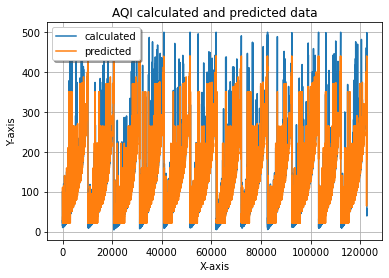

In [26]:
x_ax1 = range(0, dtr_test.count())
y_pred1 = dtr_test.select("prediction").collect()
y_orig1 = dtr_test.select("AQI").collect() 


plt.plot(x_ax1, y_orig1, label="calculated")
plt.plot(x_ax1, y_pred1, label="predicted")
plt.title("AQI calculated and predicted data")
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.show()

In [27]:
dtr_eval = RegressionEvaluator(labelCol="AQI", predictionCol="prediction", metricName="rmse")
RMSE = dtr_eval.evaluate(dtr_test)

dtr_eval = RegressionEvaluator(labelCol="AQI", predictionCol="prediction", metricName="r2")
R2 = dtr_eval.evaluate(dtr_test)

dtr_eval = RegressionEvaluator(labelCol="AQI", predictionCol="prediction", metricName="mse")
MSE = dtr_eval.evaluate(dtr_test)

dtr_eval = RegressionEvaluator(labelCol="AQI", predictionCol="prediction", metricName="mae")
MAE = dtr_eval.evaluate(dtr_test)

print("RMSE (testing) of DecisionTree: ", RMSE)
print("R Squared (testing) of DecisionTree:", R2)
print("MSE (testing) of DecisionTree: ", MSE)
print("MAE (testing) of DecisionTree: ", MAE)

RMSE (testing) of DecisionTree:  14.217594641683876
R Squared (testing) of DecisionTree: 0.9740961801077372
MSE (testing) of DecisionTree:  202.13999739523805
MAE (testing) of DecisionTree:  5.8173738714681384


In [28]:
rfr = RandomForestRegressor(featuresCol = 'features', labelCol = 'AQI',numTrees=6, maxDepth=15)
rfr.setSeed(42)

modelrfr = rfr.fit(train_aqi)
rfr_test = modelrfr.transform(test_aqi)
rfr_test.select('prediction', 'AQI').show(3)

+------------------+---+
|        prediction|AQI|
+------------------+---+
| 26.54301830771372| 27|
|14.966838592103537| 14|
|26.617474391517103| 27|
+------------------+---+
only showing top 3 rows



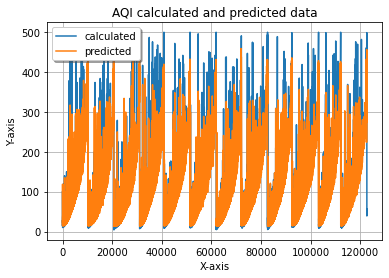

In [29]:
x_ax2 = range(0, rfr_test.count())
y_pred2 = rfr_test.select("prediction").collect()
y_orig2 = rfr_test.select("AQI").collect() 

plt.plot(x_ax2, y_orig2, label="calculated")
plt.plot(x_ax2, y_pred2, label="predicted")
plt.title("AQI calculated and predicted data")
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.show() 

In [30]:
rfr_eval = RegressionEvaluator(labelCol="AQI", predictionCol="prediction", metricName="rmse")
RMSE = rfr_eval.evaluate(rfr_test)

rfr_eval = RegressionEvaluator(labelCol="AQI", predictionCol="prediction", metricName="r2")
R2 = rfr_eval.evaluate(rfr_test)

print("RMSE (testing) of RandomForest: ", RMSE)
print("R Squared (testing) of RandomForest:", R2)

RMSE (testing) of RandomForest:  14.398662576754441
R Squared (testing) of RandomForest: 0.9734321833852009


## Air quality level

In [31]:
df_AQI.groupBy("Main_pollution").agg(count("*").alias("count")).show()

+--------------+------+
|Main_pollution| count|
+--------------+------+
|         O3_Re| 43535|
|        SO2_Re|   118|
|         CO_Re|   490|
|        NO2_Re|  8590|
|       PM10_Re| 92329|
|       PM25_Re|228517|
+--------------+------+



In [33]:
level_condition = [
    (col("AQI") <= 50, "Excellent"),
    (col("AQI") <= 100, "Good"),
    (col("AQI") <= 150, "Light Pollution"),
    (col("AQI") <= 200, "Moderate Pollution"),
    (col("AQI") <= 300, "Severe Pollution"),
    (col("AQI") > 300, "Serious Pollution")
]

df_AQI = df_AQI.withColumn("aqi_level", when(level_condition[0][0], level_condition[0][1])
                                     .when(level_condition[1][0], level_condition[1][1])
                                     .when(level_condition[2][0], level_condition[2][1])
                                     .when(level_condition[3][0], level_condition[3][1])
                                     .when(level_condition[4][0], level_condition[4][1])
                                     .otherwise("Unknown"))

df_stations = df_AQI.groupBy("aqi_level","station").agg(count("*").alias("count"))
df_stations.show()

+------------------+------------+-----+
|         aqi_level|     station|count|
+------------------+------------+-----+
|Moderate Pollution|Aotizhongxin| 2844|
|   Light Pollution|Aotizhongxin| 5959|
|  Severe Pollution|Aotizhongxin| 3617|
|           Unknown|Aotizhongxin| 1552|
|         Excellent|Aotizhongxin| 8714|
|              Good|Aotizhongxin| 8764|
|Moderate Pollution|   Changping| 2570|
|   Light Pollution|   Changping| 5232|
|           Unknown|   Changping| 1021|
|  Severe Pollution|   Changping| 3068|
|              Good|   Changping| 9368|
|         Excellent|   Changping|10823|
|Moderate Pollution|    Dingling| 2381|
|  Severe Pollution|    Dingling| 2704|
|              Good|    Dingling| 8442|
|         Excellent|    Dingling|12040|
|   Light Pollution|    Dingling| 4538|
|           Unknown|    Dingling| 1055|
|           Unknown|      Dongsi| 1685|
|Moderate Pollution|      Dongsi| 2741|
+------------------+------------+-----+
only showing top 20 rows



In [34]:
indexer_level = StringIndexer(inputCol="aqi_level", outputCol="label")
indexer_level = indexer_level.fit(df_AQI)
df_aqilevel = indexer_level.transform(df_AQI)
columns = ["PM25", "PM10","SO2","NO2","CO","O3","AQI","label"]
df_level = df_aqilevel.select(*columns)
df_level.show(10)

+----+----+---+---+---+---+---+-----+
|PM25|PM10|SO2|NO2| CO| O3|AQI|label|
+----+----+---+---+---+---+---+-----+
|   4|   4|  4|  7|300| 77| 24|  0.0|
|   8|   8|  4|  7|300| 77| 24|  0.0|
|   7|   7|  5| 10|300| 73| 23|  0.0|
|   6|   6| 11| 11|300| 72| 22|  0.0|
|   3|   3| 12| 12|300| 72| 22|  0.0|
|   5|   5| 18| 18|400| 66| 21|  0.0|
|   3|   3| 18| 32|500| 50| 16|  0.0|
|   3|   6| 19| 41|500| 43| 20|  0.0|
|   3|   6| 16| 43|500| 45| 22|  0.0|
|   3|   8| 12| 28|400| 59| 18|  0.0|
+----+----+---+---+---+---+---+-----+
only showing top 10 rows



In [35]:
assembler_level_1 = VectorAssembler(inputCols=pollution_cols, outputCol='features')
level_features_1 = assembler_level_1.transform(df_level).select('features', 'label')
train_level_1, test_level_1 = level_features_1.randomSplit([0.67, 0.33], seed=55)

level_features_1.show(3)

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[4.0,4.0,4.0,7.0,...|  0.0|
|[8.0,8.0,4.0,7.0,...|  0.0|
|[7.0,7.0,5.0,10.0...|  0.0|
+--------------------+-----+
only showing top 3 rows



In [36]:
nb = NaiveBayes(featuresCol="features", labelCol="label", smoothing=1.0)

modelnb = nb.fit(train_level_1)
nb_test = modelnb.transform(test_level_1)

evaluatornb = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="label", metricName="accuracy")
accuracy_nb = evaluatornb.evaluate(nb_test)

print("Accuracy:", accuracy_nb)

Accuracy: 0.4190648938409963


In [37]:
layers = [6, 15, 6]
mlp = MultilayerPerceptronClassifier(featuresCol='features', labelCol='label', layers=layers, blockSize=128, seed=16)

model_mlp = mlp.fit(train_level_1)
mlp_test = model_mlp.transform(test_level_1)

evaluator_mlp = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='accuracy')
accuracy_mlp = evaluator_mlp.evaluate(mlp_test)
print("Accuracy: {:.2f}%".format(accuracy_mlp * 100))

Accuracy: 56.98%


In [38]:
dt2 = DecisionTreeClassifier(maxDepth=15, labelCol="label", leafCol="leafId")
modeldt2 = dt2.fit(train_level_1)
dt_test2 = modeldt2.transform(test_level_1)
dt_test2.select('prediction', 'label').show(3)

evaluator_dt2 = MulticlassClassificationEvaluator()
accuracy_dt2 = evaluator_dt2.evaluate(dt_test2, {evaluator_dt2.metricName: "accuracy"})
print("The accuracy of DecisionTreeClassifier is:",accuracy_dt2)

+----------+-----+
|prediction|label|
+----------+-----+
|       0.0|  0.0|
|       0.0|  0.0|
|       0.0|  0.0|
+----------+-----+
only showing top 3 rows

The accuracy of DecisionTreeClassifier is: 0.9446774742092733


In [39]:
rf2 = RandomForestClassifier(numTrees=6, maxDepth=12, labelCol="label", seed=42,leafCol="leafId")
modelrf2 = rf2.fit(train_level_1)
rf_test2 = modelrf2.transform(test_level_1)
rf_test2.select('prediction', 'label').show(3)

evaluator_rf2 = MulticlassClassificationEvaluator()
evaluator_dt2.setMetricName("accuracy")
accuracy_rf2 = evaluator_rf2.evaluate(rf_test2)
print("The accuracy of RandomForestClassifier is:",accuracy_rf2)

+----------+-----+
|prediction|label|
+----------+-----+
|       0.0|  0.0|
|       0.0|  0.0|
|       0.0|  0.0|
+----------+-----+
only showing top 3 rows

The accuracy of RandomForestClassifier is: 0.955940731403258


In [40]:
features_cols = ["AQI"]
assembler_level_2 = VectorAssembler(inputCols=features_cols, outputCol='features')
level_features_2 = assembler_level_2.transform(df_level).select('features', 'label')
train_level_2, test_level_2 = level_features_2.randomSplit([0.67, 0.33], seed=55)

level_features_2.show(3)

+--------+-----+
|features|label|
+--------+-----+
|  [24.0]|  0.0|
|  [24.0]|  0.0|
|  [23.0]|  0.0|
+--------+-----+
only showing top 3 rows



In [41]:
logr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=30)
modellogr = logr.fit(train_level_2)
logr_test = modellogr.transform(test_level_2)

evaluator_logr = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="label", metricName="accuracy")
accuracy_logr = evaluator_logr.evaluate(logr_test)

print("Accuracy:", accuracy_logr)

Accuracy: 1.0


In [42]:
spark.stop()